In [26]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper
from tqdm import tqdm

In [6]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

vp_sample = vp.sample(int(1e6))[0]

V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04

t_A_aff = np.mean(vp_sample[:,2]) - t_motor
# t_A_aff = 0.05

In [7]:
ABL_arr = [40]
ILD_arr = [0]

In [8]:
N_sim = int(50e3)
N_print = int(10e3)
dt = 1e-3; dB = np.sqrt(dt);

rate_lambda = 0.076
theta_E = 50
T_0 = 0.19 * (1e-3)

t_E_aff = 0.03
Z_E = 0
L = 1

t_stim_0 = 0.2; t_stim_tau = 0.4

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                t_stim_0, t_stim_tau, iter_num, N_print, dt) for iter_num in range(N_sim))

In iter_num: 0, ABL: 40, ILD: 0, t_stim: 0.9607044345733222
In iter_num: 10000, ABL: 40, ILD: 0, t_stim: 0.5881405450233632
In iter_num: 20000, ABL: 40, ILD: 0, t_stim: 0.7124954798186731
In iter_num: 30000, ABL: 40, ILD: 0, t_stim: 0.9759716672360117
In iter_num: 40000, ABL: 40, ILD: 0, t_stim: 0.5532903335022267


In [10]:
up_rt = np.array([sim_results[i]['rt'] for i in range(N_sim) \
                  if sim_results[i]['rt'] > sim_results[i]['t_stim'] and sim_results[i]['choice'] == 1 ])

down_rt = np.array([sim_results[i]['rt'] for i in range(N_sim) \
                    if sim_results[i]['rt'] > sim_results[i]['t_stim'] and sim_results[i]['choice'] == -1 ])

In [28]:
N = 1000
t_stim_samples =  np.random.exponential(scale=t_stim_tau, size=N) + t_stim_0
t_pts_theory =  np.arange(0, 3, 0.01)
K_max = 10

up_rt_theory_vs_stim = np.zeros((N, len(t_pts_theory)))
down_rt_theory_vs_stim = np.zeros((N, len(t_pts_theory)))

for idx, t_stim in tqdm(enumerate(t_stim_samples), total=N):
    up_rt_theory_vs_stim[idx, :] = [up_RTs_fit_fn([t], V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, \
                                    theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0] for t in t_pts_theory]
    down_rt_theory_vs_stim[idx, :] = [down_RTs_fit_fn([t], V_A, theta_A, ABL_arr[0], ILD_arr[0], rate_lambda, T_0, \
                                    theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0] for t in t_pts_theory]
    


100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


In [29]:
bins = np.arange(0,3, 0.05)
up_rt_hist, _ = np.histogram(up_rt, bins=bins, density=True)
down_rt_hist, _ = np.histogram(down_rt, bins=bins, density=True)

up_rt_hist *= len(up_rt)/N_sim
down_rt_hist *= len(down_rt)/N_sim

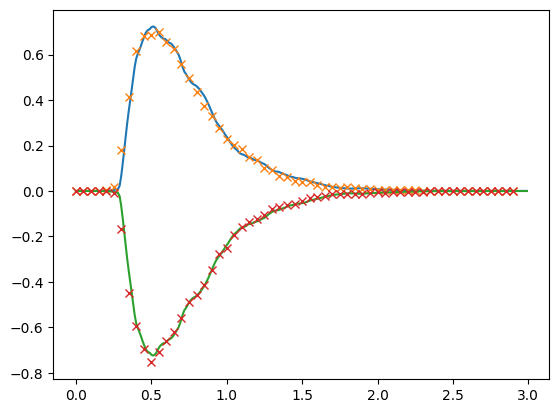

In [33]:
plt.plot(t_pts_theory, np.mean(up_rt_theory_vs_stim, axis=0), label='up')
plt.plot(bins[:-1], up_rt_hist, 'x', label='up hist')

plt.plot(t_pts_theory, -np.mean(down_rt_theory_vs_stim, axis=0), label='down')
plt.plot(bins[:-1], -down_rt_hist, 'x', label='down hist')